# Parametric shape optimization with differentiable FEM simulation

## Introduction

In this notebook, we explore the optimization of a parametric structure made of a linear elastic material.

We denote the design space as a function $g$ that maps the design variables to a signed distance field. Then, we can then define the density field $\rho(\mathbf{x})$ as a function of a signed distance field (SDF) value $g(\mathbf{x})$. For adaptive meshing, we define a sizing field $h(\mathbf{x})$ as a function of the SDF value as well.
We introduce an adpative differentiable mesher $m$ that takes the sizing field and returns a hex mesh. Finally we denote the differentiable finite element method (FEM) solver as $f$, which takes the density field and the hex mesh as input and returns the structure's compliance.  Therefore, the optimization problem can be formulated as follows:

$$
\begin{equation}
\min_{\theta} f(m(g(\theta)), \rho(g(\theta))).
\end{equation}
$$

Here, $\theta$ is the vector of design variables.

## Setup

In [357]:
# Install additional requirements for this notebook
# %pip install -r requirements.txt -q --isolated

In [358]:
# import tesseract_core

# tesseract_core.build_tesseract("design_tess", "latest")
# tesseract_core.build_tesseract("fem_tess", "latest")
# tesseract_core.build_tesseract("meshing_tess", "latest")
# print("Tesseract built successfully.")

## Design Space Tesseract

In [359]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tesseract_core import Tesseract
from tesseract_core.runtime.experimental import TesseractReference

from tesseract_jax import apply_tesseract

In [360]:
# design_tess = Tesseract.from_image("design-tube-sdf")
# design_tess.serve()
design_tess = Tesseract.from_tesseract_api("sdf_fd_tess/tesseract_api.py")
bar_3d_tess = Tesseract.from_tesseract_api("bars_3d_tess/tesseract_api.py")

Now we can setup the parameters for the design space and apply the design Tesseract. The Tesseract constructs a 3D geometry using PyVista and computes its signed distance field (SDF).

In [361]:
n_chains = 2
n_edges_per_chain = 3
bar_radius = 1.2

Lx, Ly, Lz = 20.0, 10.0, 10.0
Nx, Ny, Nz = 128, 64, 64

# Initialize chain parameter array
initial_params = jnp.zeros((n_chains, n_edges_per_chain + 1, 3), dtype=jnp.float32)

for chain in range(n_chains):
    initial_params = initial_params.at[chain, :, 0].set(
        jnp.linspace(-Lx / 2, Lx / 2, n_edges_per_chain + 1)
    )

    initial_params = initial_params.at[chain, :, 2].set(
        (chain + 1) / (n_chains + 1) * Ly - Ly / 2
    )

initial_params = initial_params.at[0, 0, 2].set(-5)

initial_params = initial_params.flatten()

normalization_factors = jnp.ones_like(initial_params, dtype=jnp.float32) * 0.1
initial_params = initial_params * normalization_factors
normalization_bias = jnp.zeros_like(initial_params, dtype=jnp.float32)


design_inputs = {
    "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
    "static_parameters": [n_chains, n_edges_per_chain + 1],
    "string_parameters": [],
    "mesh_tesseract": TesseractReference(bar_3d_tess),
    "grid_size": [Lx, Ly, Lz],
    "grid_elements": [Nx, Ny, Nz],
    "epsilon": 0.001,  # epsilon, only used for FD of the jacobian
    "grid_center": [0.0, 0.0, 0.0],
    "max_points": 2000,
    "max_faces": 4000,
    "normalization_factors": normalization_factors,
    "normalization_bias": normalization_bias,
    "normalize_jacobian": False,
    "precompute_jacobian": False,
    "sdf_backend": "pyvista",
}

design_out = design_tess.apply(
    {
        "differentiable_parameters": initial_params,
        **design_inputs,
    }
)
sdf = design_out["sdf"]
surface_mesh = design_out["mesh"]

num_vertices = surface_mesh["n_points"]
num_faces = surface_mesh["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

points = surface_mesh["points"][:num_vertices]
faces = surface_mesh["faces"][:num_faces]

mesh = {
    "points": points,
    "faces": faces,
}

print("SDF shape:", sdf.shape)

Number of vertices: 240
Number of faces: 472
SDF shape: (128, 64, 64)


To better understand what's going on, let's import some internal functions from the design Tesseract, and visualize the structure and its SDF field.

TODOs>
- fix bcs
- plot parts of jacobian for parameters
- scaling VN bcs instead of gradients in FD


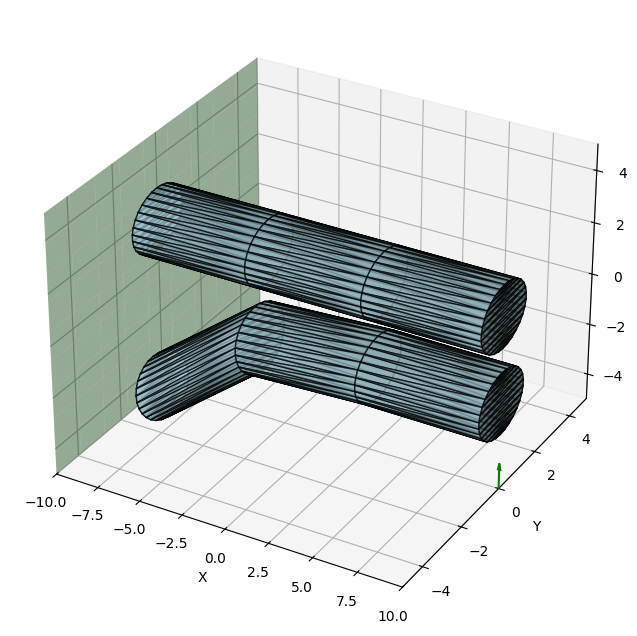

In [362]:
def plot_mesh(mesh: dict, save_path: str | None = None) -> None:
    """Plot a 3D triangular mesh with boundary conditions visualization.

    Args:
        mesh: Dictionary containing 'points' and 'faces' arrays.
        save_path: Optional path to save the plot as an image file.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_trisurf(
        mesh["points"][:, 0],
        mesh["points"][:, 1],
        mesh["points"][:, 2],
        triangles=mesh["faces"],
        alpha=0.7,
        antialiased=True,
        color="lightblue",
        edgecolor="black",
    )

    # plane on x=0 to visualize dirichlet boundary
    yy, zz = jnp.meshgrid(
        jnp.linspace(-Ly / 2, Ly / 2, 10), jnp.linspace(-Ly / 2, Ly / 2, 10)
    )
    xx = -jnp.ones_like(yy) * Lx / 2
    ax.plot_surface(xx, yy, zz, alpha=0.4, color="green")

    ax.set_xlim(-Lx / 2, Lx / 2)
    ax.set_ylim(-Ly / 2, Ly / 2)
    ax.set_zlim(-Lz / 2, Lz / 2)

    # x axis label
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # green arrow on bottom right to indicate force direction
    ax.quiver(
        Lx / 2,
        0,
        -Lz / 2,
        0,
        0,
        1,
        length=1.0,
        color="green",
        arrow_length_ratio=0.3,
    )

    if save_path:
        # avoid showing the plot in notebook
        plt.savefig(save_path)
        plt.close(fig)


plot_mesh(mesh)

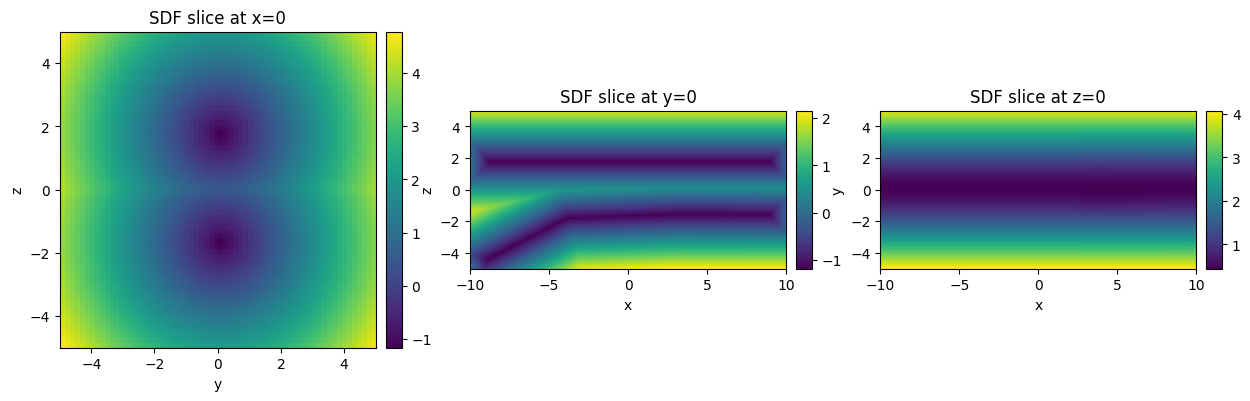

In [363]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_grid_slice(field_slice, extent, ax, title, xlabel, ylabel, log_scale=False):
    im = ax.imshow(field_slice.T, extent=extent, origin="lower")
    # norm=colors.CenteredNorm())
    # norm=colors.LogNorm(vmin=field_slice.min().item(), vmax=field_slice.max().item()) if log_scale else None)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax, orientation="vertical")
    return im


def plot_grid(field, Lx, Ly, Lz, Nx, Ny, Nz):
    _, axs = plt.subplots(1, 3, figsize=(15, 5))

    plot_grid_slice(
        field[Nx // 2, :, :],
        extent=(-Ly / 2, Ly / 2, -Lz / 2, Lz / 2),
        ax=axs[0],
        title="SDF slice at x=0",
        xlabel="y",
        ylabel="z",
    )
    plot_grid_slice(
        field[:, Ny // 2, :],
        extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
        ax=axs[1],
        title="SDF slice at y=0",
        xlabel="x",
        ylabel="z",
    )
    plot_grid_slice(
        field[:, :, Nz // 2],
        extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
        ax=axs[2],
        title="SDF slice at z=0",
        xlabel="x",
        ylabel="y",
    )


plot_grid(sdf, Lx, Ly, Lz, Nx, Ny, Nz)

And figure out an approate epsilon for finite difference based Jacobian computation.

In [364]:
# # Lets figure out a good epsilon value for FD jacobian computation
# epsilons = jnp.logspace(-6, -1, 5)
# mean_grads = []
# std_grads = []

# for i in range(len(epsilons)):
#     eps = epsilons[i]

#     design_inputs_eps = design_inputs.copy()
#     design_inputs_eps["epsilon"] = eps.item()

#     primal, vjp_fun = jax.vjp(
#         lambda params,  design_params=design_inputs_eps: apply_tesseract(
#             design_tess,
#             {
#                 "differentiable_parameters": params.flatten(),
#                 **design_params,
#             },
#         )["sdf"],
#         initial_params,
#     )

#     grad = vjp_fun(jnp.ones((Nx, Ny, Nz), dtype=jnp.float32))[0]

#     mean_grads.append(jnp.mean(jnp.abs(grad)))
#     std_grads.append(jnp.std(grad))

In [365]:
# plt.figure(figsize=(8, 6))
# plt.plot(epsilons, mean_grads, marker="o")
# plt.plot(epsilons, std_grads, marker="x")
# plt.xlabel("Epsilon")
# plt.xscale("log")
# plt.yscale("log")
# plt.ylabel("Mean Absolute Gradient")
# plt.title("Effect of Epsilon on Gradient Magnitude")
# plt.grid(True)
# plt.legend(["Mean Gradient", "Std Dev of Gradient"])

In [366]:
result = design_tess.jacobian(
    inputs={
        "differentiable_parameters": initial_params,
        **design_inputs,
    },
    jac_inputs=["differentiable_parameters"],
    jac_outputs=["sdf"],
)

Computing Jacobian...


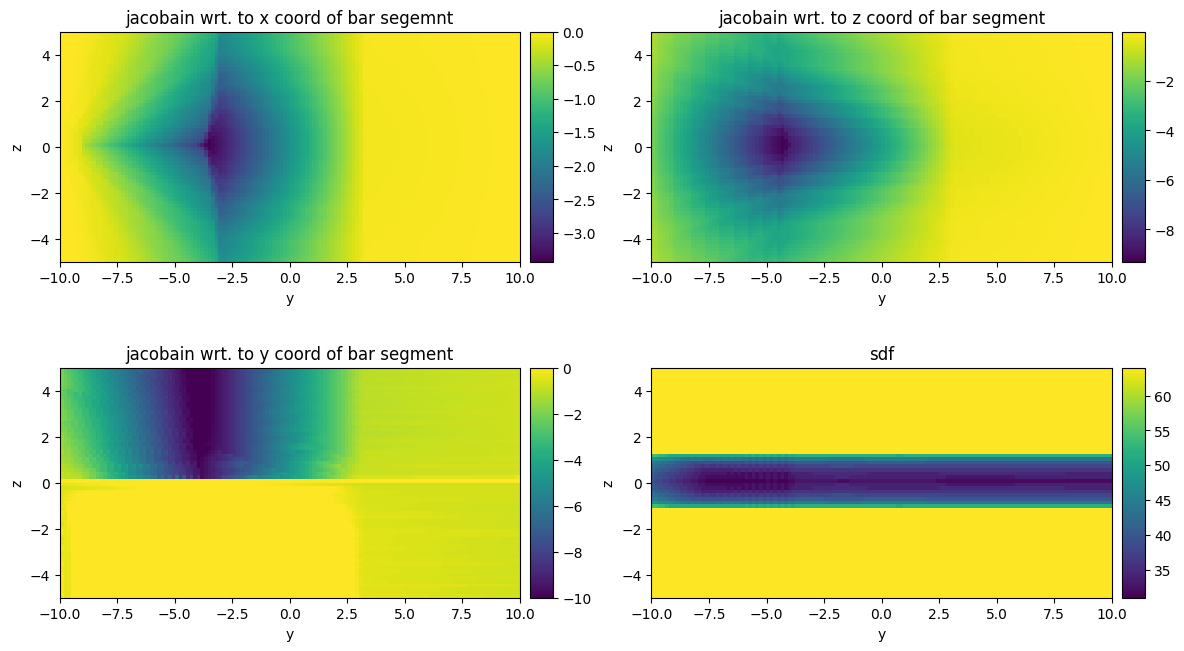

In [367]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

plot_grid_slice(
    jnp.min(jnp.clip(result["sdf"]["differentiable_parameters"][3], -10, 0), 2),
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 0],
    title="jacobain wrt. to x coord of bar segemnt",
    xlabel="y",
    ylabel="z",
    log_scale=True,
)

plot_grid_slice(
    jnp.min(jnp.clip(result["sdf"]["differentiable_parameters"][4], -10, 0), 2),
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[1, 0],
    title="jacobain wrt. to y coord of bar segment",
    xlabel="y",
    ylabel="z",
    log_scale=True,
)

plot_grid_slice(
    jnp.min(jnp.clip(result["sdf"]["differentiable_parameters"][5], -10, 0), 2),
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[0, 1],
    title="jacobain wrt. to z coord of bar segment",
    xlabel="y",
    ylabel="z",
    log_scale=True,
)

plot_grid_slice(
    jnp.sum(sdf > 0, 2),
    extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
    ax=axs[1, 1],
    title="sdf",
    xlabel="y",
    ylabel="z",
    log_scale=True,
)

## Density and Sizing Field

rho min: 7.108275167411193e-05, rho max: 0.921584963798523


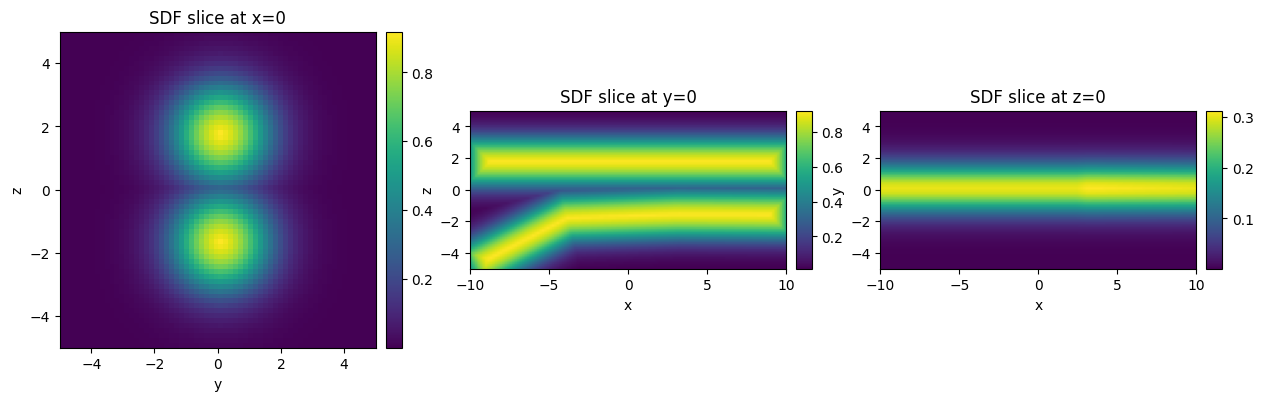

In [368]:
def sdf_to_rho(
    sdf: jnp.ndarray, scale: float = 2.0, offset: float = 0.1
) -> jnp.ndarray:
    """Convert signed distance function to material density using sigmoid.

    Args:
        sdf: Signed distance function values.
        scale: Sigmoid steepness (higher = sharper transition).
        offset: SDF value where density = 0.5.

    Returns:
        Material density field in [0,1].
    """
    return 1 / (1 + jnp.exp(scale * sdf - offset))


rho = sdf_to_rho(sdf, scale=2)

plot_grid(rho, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"rho min: {jnp.min(rho)}, rho max: {jnp.max(rho)}")

Sizing field min: 0.625, max: 2.5


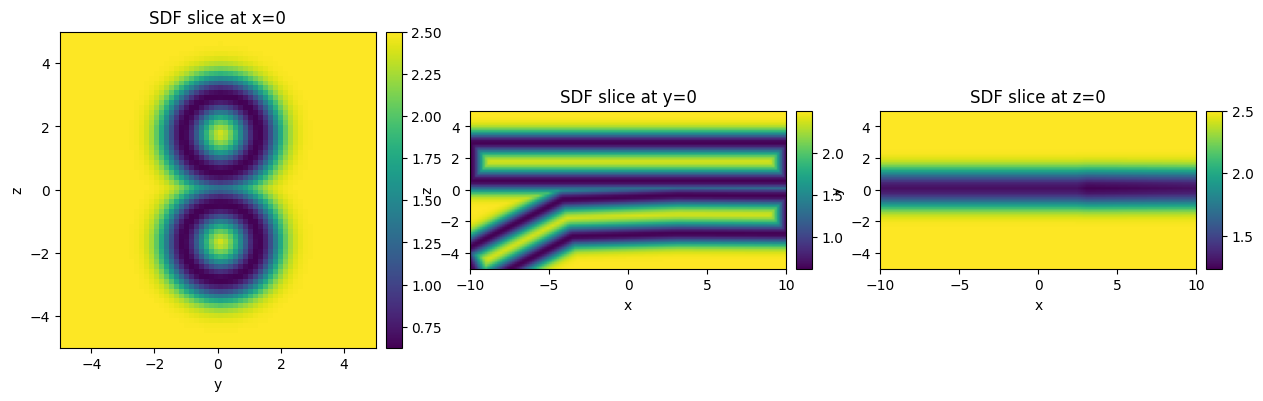

In [369]:
def sizing_field(
    sdf: jnp.ndarray, min_size: float = 0.1, max_size: float = 1.0, scale: float = 2.0
) -> jnp.ndarray:
    """Generate a sizing field from the signed distance function.

    The field is low (size = min_size) near the structure (sdf=0) and high (size = max_size) far from it.

    Args:
        sdf: Signed distance function values.
        min_size: Minimum element size near the structure.
        max_size: Maximum element size far from the structure.
        scale: Controls the transition steepness.

    Returns:
        Sizing field values.
    """

    def gauss(x: jnp.ndarray, mu: float, sigma: float) -> jnp.ndarray:
        return jnp.exp(-0.5 * ((x - mu) / sigma) ** 2)

    normalized_sdf = 1 - gauss(sdf, 0.0, 1.0 / scale)
    return min_size + (max_size - min_size) * normalized_sdf


sizing_min = Lx / 32
sizing_max = Lx / 8
sizing_scale = 2.0
sizing = sizing_field(sdf, min_size=sizing_min, max_size=sizing_max, scale=sizing_scale)
plot_grid(sizing, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"Sizing field min: {sizing.min()}, max: {sizing.max()}")

## Adpative Hex Meshing Tesseract

In [370]:
mesher = Tesseract.from_tesseract_api("meshing_tess/tesseract_api.py")

max_points = 30000
max_cells = 30000

mesher_out = apply_tesseract(
    mesher,
    {
        "domain_size": [Lx, Ly, Lz],
        "sizing_field": sizing,
        "field_values": rho,
        "max_subdivision_levels": 3,
        "max_points": max_points,
        "max_cells": max_cells,
    },
)
print(
    f"Mesh points: {mesher_out['mesh']['n_points']}, Mesh faces: {mesher_out['mesh']['n_faces']}"
)
pts = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]

adaptive_mesh = mesher_out["mesh"]

print(jnp.max(mesher_out["mesh_cell_values"]))
print(mesher_out["mesh_cell_values"].shape)

Done building mesh
Mesh points: 10834, Mesh faces: 8806
0.9024124
(30000,)


Lets check the gradient of the meshing Tesseract

In [371]:
# primal, vjp_fun = jax.vjp(
#     lambda rho: apply_tesseract(
#         mesher,
#         {
#             "domain_size": [Lx, Ly, Lz],
#             "sizing_field": sizing,
#             "field_values": rho,
#             "max_subdivision_levels": 3,
#             "max_points": max_points,
#             "max_cells": max_cells,
#         },
#     )["mesh_cell_values"],
#     rho,
# )

# grad = vjp_fun(jax.numpy.ones((max_cells), dtype=jax.numpy.float32) * 0.5)[0]

# print("Gradient shape:", grad.shape)
# print(f"Max grad: {jnp.max(grad)}, Min grad: {jnp.min(grad)}")

Lets examine the produced mesh by exporting it to a VTK file and visualizing it in Paraview.

In [372]:
# Lets export it to a .vtk using pyvista
import numpy as np
import pyvista as pv


def hex_to_pyvista(
    pts: jax.typing.ArrayLike, faces: jax.typing.ArrayLike, cell_data: dict
) -> pv.UnstructuredGrid:
    """Convert hex mesh defined by points and faces into a PyVista UnstructuredGrid.

    Args:
        pts: Array of point coordinates, shape (N, 3).
        faces: Array of hexahedral cell connectivity, shape (M, 8).
        cell_data: additional cell center data.

    Returns:
        PyVista mesh representing the hexahedral grid.
    """
    pts = np.array(pts)
    faces = np.array(faces)

    # Define the cell type for hexahedrons (VTK_HEXAHEDRON = 12)
    cell_type = pv.CellType.HEXAHEDRON
    cell_types = np.array([cell_type] * faces.shape[0], dtype=np.uint8)

    # Prepare the cells array: [number_of_points, i0, i1, i2, i3, i4, i5, i6, i7]
    n_cells = faces.shape[0]
    cells = np.empty((n_cells, 9), dtype=np.int64)
    cells[:, 0] = 8  # Each cell has 8 points
    cells[:, 1:9] = faces

    # Flatten the cells array for PyVista
    cells = cells.flatten()

    mesh = pv.UnstructuredGrid(cells, cell_types, pts)

    # Add cell data
    for name, data in cell_data.items():
        mesh.cell_data[name] = data

    return mesh


# convert arrays to numpy
pts_np = np.array(adaptive_mesh["points"][: adaptive_mesh["n_points"]])
cells_np = np.array(adaptive_mesh["faces"][: adaptive_mesh["n_faces"]])

hex_mesh = hex_to_pyvista(
    pts_np,
    cells_np,
    {"rho": mesher_out["mesh_cell_values"][: adaptive_mesh["n_faces"]]},
)

print(hex_mesh)

hex_mesh.save("bars_mesh.vtk")

UnstructuredGrid (0x77b492dbe2c0)
  N Cells:    8806
  N Points:   10834
  X Bounds:   -1.000e+01, 1.000e+01
  Y Bounds:   -5.000e+00, 5.000e+00
  Z Bounds:   -5.000e+00, 5.000e+00
  N Arrays:   1


## Boundary Conditions

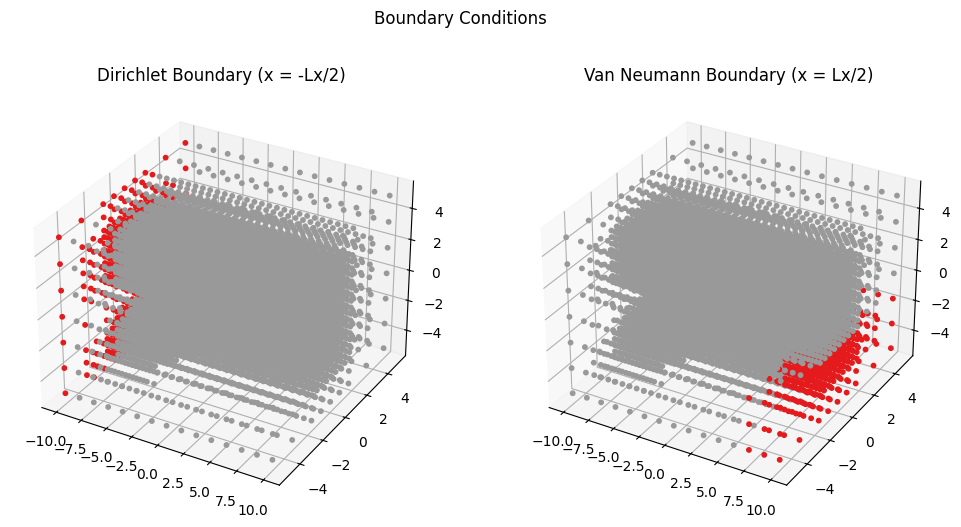

In [373]:
# Lets setup the boundary conditions


def get_boundary_masks(mesh: dict, Lx: float, Lz: float):
    """Get boundary condition masks for the adaptive mesh.

    Args:
        mesh: Dictionary containing 'points' array.
        Lx: Size of the domain in x-direction.
        Lz: Size of the domain in z-direction.

    Returns:
        dirichlet_mask: Boolean array for Dirichlet boundary condition.
        van_neumann_mask: Boolean array for Van Neumann boundary condition.
    """
    pts = mesh["points"]

    dirichlet_mask = pts[:, 0] <= -Lx / 2 + Lx / 20
    van_neumann_mask = jnp.logical_and(
        jnp.isclose(pts[:, 0], Lx / 2, atol=Lz / 3),
        jnp.isclose(pts[:, 2], -Lz / 2, atol=Lz / 3),
    )

    return dirichlet_mask, van_neumann_mask


dirichlet_mask, van_neumann_mask = get_boundary_masks(adaptive_mesh, Lx, Lz)

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
# set the colormap to Set1
plt.suptitle("Boundary Conditions")
# remove the axis ticks
pts = adaptive_mesh["points"][: adaptive_mesh["n_points"]]

axs[0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(dirichlet_mask[: adaptive_mesh["n_points"]], 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[0].set_title("Dirichlet Boundary (x = -Lx/2)")

axs[1].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(van_neumann_mask[: adaptive_mesh["n_points"]], 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[1].set_title("Van Neumann Boundary (x = Lx/2)")

# convert to int arrays for tesseract input
dirichlet_mask = dirichlet_mask.astype(jnp.int32)
van_neumann_mask = van_neumann_mask.astype(jnp.int32)

In [374]:
# fem_tess = Tesseract.from_image("structure-jax-fem")
# fem_tess.serve()

fem_tess = Tesseract.from_tesseract_api("fem_tess/tesseract_api.py")

In [375]:
# compliance = apply_tesseract(
#     fem_tess,
#     {
#         "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
#         "hex_mesh": adaptive_mesh,
#         "dirichlet_mask": dirichlet_mask,
#         "dirichlet_values": jnp.array([0.0]),
#         "van_neumann_mask": van_neumann_mask,
#         "van_neumann_values": jnp.array([[0.0, 0.0, 1.0]]),
#     },
# )["compliance"]
# print(f"Compliance: {compliance:.4f}")

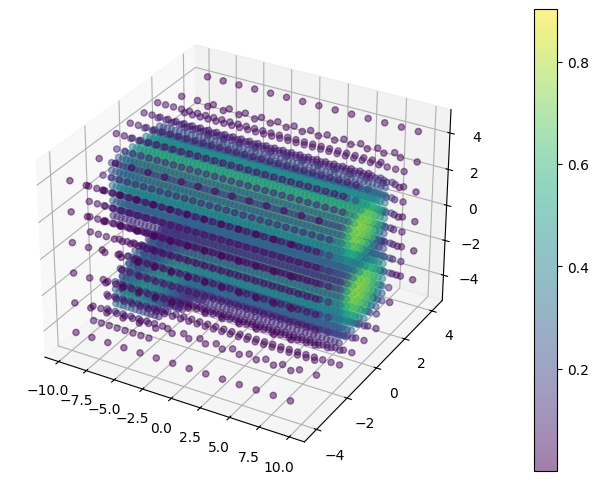

In [376]:
# lets make a scatter plot of the mesh cell values as colors
fig, ax = plt.subplots(1, 1, figsize=(8, 6), subplot_kw={"projection": "3d"})
pts_coords = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]
center_points = jnp.mean(pts_coords[hex_cells], axis=1)
rho_mesh = mesher_out["mesh_cell_values"][: mesher_out["mesh"]["n_faces"]]
scat = ax.scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=rho_mesh,
    s=20,
    # alpha=rho+0.3,
    alpha=0.5,
    cmap="viridis",
)
# colorbar
cbar = plt.colorbar(scat, ax=ax, pad=0.1)

In [333]:
from typing import TypeVar

T = TypeVar("T")


def stop_grads_int(x: T) -> T:
    """Stops gradient computation.

    We cannot use jax.lax.stop_gradient directly because Tesseract meshes are
    nested dictionaries with arrays and integers, and jax.lax.stop_gradient
    does not support integers.

    Args:
        x: Input value.

    Returns:
        Value with stopped gradients.
    """

    def stop(x):
        return jax._src.ad_util.stop_gradient_p.bind(x)

    return jax.tree_util.tree_map(stop, x)

In [334]:
from jax import custom_vjp

grad_storage = {}


def store_values(x, x_dot, hash_val: int):
    global grad_storage
    print("Storing values in hash", hash_val)
    grad_storage[int(hash_val)] = (x, x_dot)


@custom_vjp
def identity_and_store_grads(x, hash_val: int):
    return x


def identity_fwd(x, hash_val):
    return x, (x, hash_val)


def identity_bwd(residuals, g):
    x, hash_val = residuals
    jax.debug.callback(store_values, x, g, hash_val, ordered=False)
    return (g, None)


identity_and_store_grads.defvjp(identity_fwd, identity_bwd)

In [335]:
max_points = 15000
max_cells = 15000


def loss(
    params: jnp.ndarray,
    iteration: int = 0,
) -> tuple[float, dict]:
    """Compute structural compliance for given bar parameters.

    Args:
        params: Bar parameter array with shape (n_chains, n_nodes, 3).
        iteration: current optim iteration.

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    # Generate signed distance field from design parameters
    # params = identity_and_store_grads(params, iteration + 0)
    design_out = apply_tesseract(
        design_tess,
        {"differentiable_parameters": params.flatten(), **design_inputs},
    )

    sdf = design_out["sdf"]

    sdf = identity_and_store_grads(sdf, iteration + 1000)

    # Convert SDF to material density distribution
    rho_grid = sdf_to_rho(sdf, scale=2)

    rho_grid = identity_and_store_grads(rho_grid, iteration + 2000)

    sizing = sizing_field(
        sdf, min_size=sizing_min, max_size=sizing_max, scale=sizing_scale
    )
    sizing = jax.lax.stop_gradient(sizing)

    mesher_out = apply_tesseract(
        mesher,
        {
            "domain_size": [Lx, Ly, Lz],
            "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
            "field_values": rho_grid,
            "max_subdivision_levels": 2,
            "max_points": max_points,
            "max_cells": max_cells,
        },
    )

    rho_cell = jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1)
    rho_cell = identity_and_store_grads(rho_cell, iteration + 3000)

    mesh = stop_grads_int(mesher_out["mesh"])

    dirichlet_mask, van_neumann_mask = get_boundary_masks(mesh, Lx, Lz)

    van_neumann_mask = jax.lax.stop_gradient(van_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    dirichlet_values = jnp.array([0.0])
    van_neumann_values = jnp.array([[0.0, 0.0, 0.1]])

    # Instead of passing all inputs and trying to stop_gradient on them,
    # we need to wrap the tesseract call to only allow gradients w.r.t. rho
    c = apply_tesseract(
        fem_tess,
        {
            "rho": rho_cell,
            "hex_mesh": mesh,
            "dirichlet_mask": dirichlet_mask,
            "dirichlet_values": dirichlet_values,
            "van_neumann_mask": van_neumann_mask,
            "van_neumann_values": van_neumann_values,
        },
    )["compliance"]

    surface_mesh = {
        "points": design_out["mesh"]["points"][: design_out["mesh"]["n_points"]],
        "faces": design_out["mesh"]["faces"][: design_out["mesh"]["n_faces"]],
    }

    hex_mesh = {
        "points": mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]],
        "faces": mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]],
        "rho": mesher_out["mesh_cell_values"][: mesher_out["mesh"]["n_faces"]],
    }

    return c, {
        "sdf": sdf,
        "rho_grid": rho_grid,
        "sizing": sizing,
        "hex_mesh": hex_mesh,
        "surface_mesh": surface_mesh,
    }

In [336]:
grad_fn = jax.value_and_grad(loss, has_aux=True)

## Lets have a look at the gradients

In [337]:
(loss_value, aux), grads = grad_fn(initial_params, iteration=0)
print(f"loss {loss_value}, grads {grads}")

Done building mesh


[11-21 15:28:37][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-21 15:28:37][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-21 15:28:37][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-21 15:28:39][DEBUG] jax_fem: Done pre-computations, took 1.1220717430114746 [s]
[11-21 15:28:39][INFO] jax_fem: Solving a problem with 2464 cells, 3199x3 = 9597 dofs.
[11-21 15:28:39][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-21 15:28:40][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-21 15:28:40][DEBUG] jax_fem: Start timing
[11-21 15:28:40][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-21 15:28:41][DEBUG] jax_fem: Function split_and_compute_cell took 0.5252 seconds
[11-21 15:28:42][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-21 15:28:43][DEBUG] jax_fem: Before, l_2 res = 5.001482919423332, relative l_2 res

Storing values in hash 3000
Done building mesh
Storing values in hash 2000
Storing values in hash 1000
Computing Jacobian...
loss 30.739221572875977, grads [ 5.5806231e-01 -2.1873677e+00 -1.8421693e+00  3.3389815e-14
 -1.3982209e+00 -2.2100177e+00  6.7612046e-15 -1.1114326e+00
  6.5901935e-01 -7.0419866e-03 -1.3645653e+00  3.0822701e+00
  4.6622351e-01 -1.1294160e+00 -1.7552319e+00  3.2892797e-14
 -1.3244025e+00 -2.1347806e+00 -2.7186454e-15 -3.4139357e+00
  4.7414169e-01 -6.3064550e-03 -3.5220008e+00  2.6121643e+00]


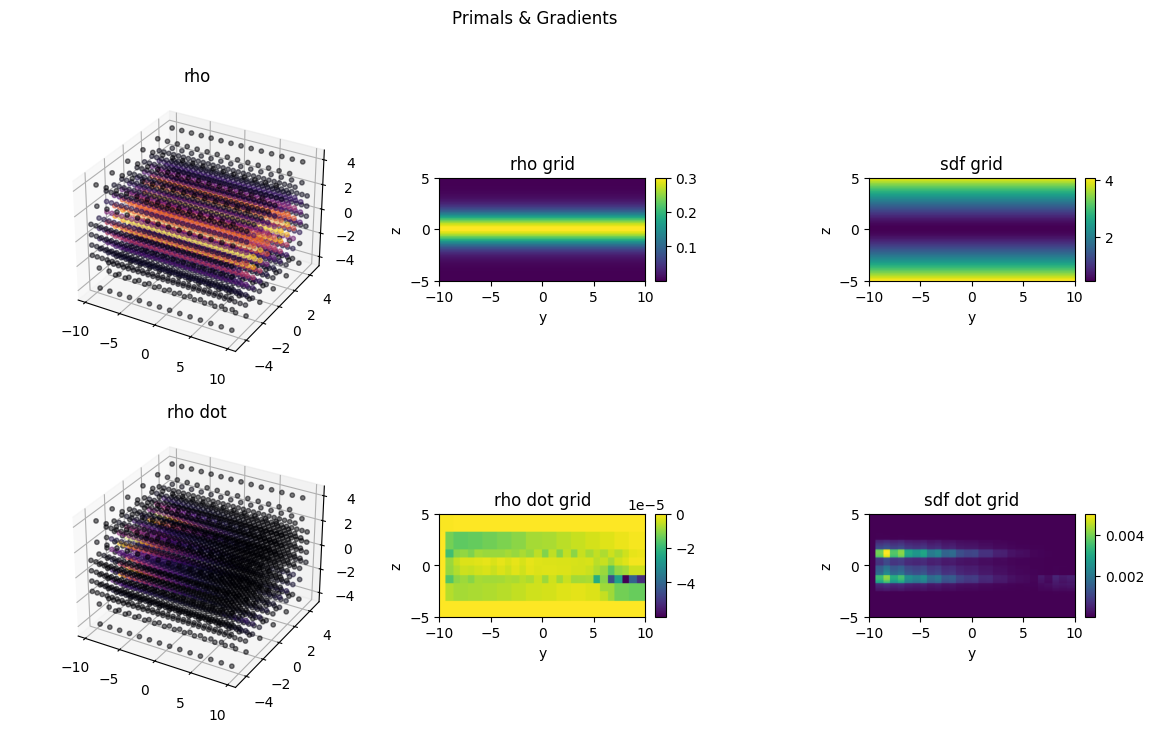

In [338]:
fig, axs = plt.subplots(2, 3, figsize=(14, 8))
plt.suptitle("Primals & Gradients")
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

ax = axs[0, 0]
for spine in ax.spines.values():
    spine.set_visible(False)

ax = axs[1, 0]
for spine in ax.spines.values():
    spine.set_visible(False)

# Set the first two subplots to 3D
axs[0, 0] = fig.add_subplot(2, 2, 1, projection="3d")
axs[1, 0] = fig.add_subplot(2, 2, 3, projection="3d")


mesh = aux["hex_mesh"]

pts_coords = mesh["points"]
hex_cells = mesh["faces"]
pts = jnp.mean(pts_coords[hex_cells], axis=1)

axs[0, 0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=mesh["rho"],
    s=10,
    alpha=0.5,
    cmap="inferno",
)
axs[0, 0].set_title("rho")

axs[1, 0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=-grad_storage[3000][1][: mesh["rho"].shape[0]],
    s=10,
    alpha=0.5,
    cmap="inferno",
)
axs[1, 0].set_title("rho dot")

plot_grid_slice(
    aux["rho_grid"][:, Ny // 2, :],
    extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
    ax=axs[0, 1],
    title="rho grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    jnp.max(grad_storage[2000][1], axis=1),
    extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
    ax=axs[1, 1],
    title="rho dot grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    aux["sdf"][:, Ny // 2, :],
    extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
    ax=axs[0, 2],
    title="sdf grid",
    xlabel="y",
    ylabel="z",
)

plot_grid_slice(
    jnp.max(grad_storage[1000][1], axis=1),
    extent=(-Lx / 2, Lx / 2, -Lz / 2, Lz / 2),
    ax=axs[1, 2],
    title="sdf dot grid",
    xlabel="y",
    ylabel="z",
)

fig.subplots_adjust(wspace=0.9)
# fig.tight_layout(w_pad=3.0)

In [339]:
print(grads)

[ 5.5806231e-01 -2.1873677e+00 -1.8421693e+00  3.3389815e-14
 -1.3982209e+00 -2.2100177e+00  6.7612046e-15 -1.1114326e+00
  6.5901935e-01 -7.0419866e-03 -1.3645653e+00  3.0822701e+00
  4.6622351e-01 -1.1294160e+00 -1.7552319e+00  3.2892797e-14
 -1.3244025e+00 -2.1347806e+00 -2.7186454e-15 -3.4139357e+00
  4.7414169e-01 -6.3064550e-03 -3.5220008e+00  2.6121643e+00]


In [378]:
import optax

n_steps = 10
# strong learning rate decay
schedule = optax.exponential_decay(
    init_value=0.05, transition_steps=n_steps, decay_rate=0.9, staircase=False
)
optmizer = optax.adam(learning_rate=schedule)
opt_state = optmizer.init(initial_params)

params = initial_params.copy()
loss_hist = []
params_hist = []
aux_hist = []


for i in range(n_steps):
    (loss_value, aux), grads = grad_fn(params, iteration=i)
    aux_hist.append(aux)

    print(grads)
    print(params)

    updates, opt_state = optmizer.update(
        grads, opt_state, params, value=loss_value, grad=grads, value_fn=loss
    )
    params = optax.apply_updates(params, updates)

    # # Ensure parameters are within bounds
    params = params.at[::3].set(initial_params.at[::3].get())

    # params = params.at[1::3].set(
    #     jnp.clip(params[1::3], -Ly / 2 + bar_radius, Ly / 2 - bar_radius)
    # )

    # params = params.at[2::3].set(
    #     jnp.clip(params[2::3], -Lz / 2 + bar_radius, Lz / 2 - bar_radius)
    # )

    loss_hist.append(loss_value)
    params_hist.append(params)

    print(f"Iteration {i + 1}, Loss: {loss_value:.4f}")

Done building mesh


[11-21 16:31:13][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-21 16:31:13][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-21 16:31:13][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-21 16:31:14][DEBUG] jax_fem: Done pre-computations, took 1.1059064865112305 [s]
[11-21 16:31:14][INFO] jax_fem: Solving a problem with 2471 cells, 3230x3 = 9690 dofs.
[11-21 16:31:14][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-21 16:31:15][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-21 16:31:15][DEBUG] jax_fem: Start timing
[11-21 16:31:15][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-21 16:31:16][DEBUG] jax_fem: Function split_and_compute_cell took 0.4891 seconds
[11-21 16:31:17][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-21 16:31:17][DEBUG] jax_fem: Before, l_2 res = 4.898011549211379, relative l_2 res

Storing values in hash 3000
Done building mesh
Storing values in hash 2000
Storing values in hash 1000
Computing Jacobian...
[-2.8808621e-01 -4.4990617e-01  2.4380612e+00 -4.3985023e+00
 -5.1886523e-01  1.3081539e+01 -3.9634049e-02  4.3454912e-01
  3.8821362e-02  3.1040090e-01  9.8815876e-01  1.6034254e+00
  1.3933687e-01  9.9236220e-01 -6.4347019e+00  5.4351394e-15
  8.4577090e-01 -9.5401487e+00  5.0412098e-15  1.5838041e+00
  3.2465062e+00 -1.7689501e-03  1.6967546e+00  1.7885422e+00]
[-1.          0.         -0.5        -0.33333334  0.         -0.16666667
  0.33333334  0.         -0.16666667  1.          0.         -0.16666667
 -1.          0.          0.16666667 -0.33333334  0.          0.16666667
  0.33333334  0.          0.16666667  1.          0.          0.16666667]
Iteration 1, Loss: 7.4819
Done building mesh


[11-21 16:32:14][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-21 16:32:14][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-21 16:32:14][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-21 16:32:15][DEBUG] jax_fem: Done pre-computations, took 1.1284990310668945 [s]
[11-21 16:32:15][INFO] jax_fem: Solving a problem with 2135 cells, 2848x3 = 8544 dofs.
[11-21 16:32:15][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-21 16:32:17][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-21 16:32:17][DEBUG] jax_fem: Start timing
[11-21 16:32:17][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-21 16:32:18][DEBUG] jax_fem: Function split_and_compute_cell took 0.4811 seconds
[11-21 16:32:19][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-21 16:32:19][DEBUG] jax_fem: Before, l_2 res = 5.03445017226126, relative l_2 res 

Storing values in hash 3001
Done building mesh
Storing values in hash 2001
Storing values in hash 1001
Computing Jacobian...
[ 4.5286059e-01  5.4686441e+00 -3.5032308e-01 -1.4140104e+00
  1.1528154e+01  6.8605585e+00 -5.4376936e-01  2.6643395e-01
 -4.8951454e+00  4.3115056e-01  7.8508466e-01  2.0019145e-01
  3.1217867e-01 -6.6006756e+00 -7.7056580e+00 -5.0530207e-01
 -1.0727371e+01 -5.7640843e+00  2.7058989e-01 -2.4890039e+00
  3.1548071e+00 -4.3608109e-04 -8.6549006e-02  2.0369849e+00]
[-1.          0.05       -0.55       -0.33333334  0.05       -0.21666668
  0.33333334 -0.05       -0.21666665  1.         -0.05000001 -0.21666667
 -1.         -0.05        0.21666668 -0.33333334 -0.05        0.21666667
  0.33333334 -0.05        0.11666667  1.         -0.05        0.11666667]
Iteration 2, Loss: 7.1608
Done building mesh


[11-21 16:33:39][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-21 16:33:39][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-21 16:33:39][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-21 16:33:40][DEBUG] jax_fem: Done pre-computations, took 1.1216115951538086 [s]
[11-21 16:33:40][INFO] jax_fem: Solving a problem with 2163 cells, 2904x3 = 8712 dofs.
[11-21 16:33:40][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-21 16:33:41][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-21 16:33:41][DEBUG] jax_fem: Start timing
[11-21 16:33:42][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-21 16:33:42][DEBUG] jax_fem: Function split_and_compute_cell took 0.4737 seconds
[11-21 16:33:43][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-21 16:33:43][DEBUG] jax_fem: Before, l_2 res = 5.03445017226126, relative l_2 res 

Storing values in hash 3002
Done building mesh
Storing values in hash 2002
Storing values in hash 1002
Computing Jacobian...
[ 2.1105213   1.3728752  -3.9119     -0.8924699   2.6802871   2.6792622
 -0.23507077 -4.211764    1.3197883   0.07813574 -1.2026558   1.0838735
  0.26021114 -2.2625895  -6.2074785  -0.44973767 -1.6992726  -2.5063024
 -0.17542225  0.18734339 -1.5890409  -0.09864704 -0.23465678  0.8812365 ]
[-1.          0.01602383 -0.57757545 -0.33333334  0.01471017 -0.263129
  0.33333334 -0.09750979 -0.1801137   1.         -0.09886117 -0.2541263
 -1.         -0.01851819  0.2661749  -0.33333334 -0.01590128  0.26408383
  0.33333334 -0.03672511  0.06723273  1.         -0.08123221  0.06712756]
Iteration 3, Loss: 5.6707
Done building mesh


[11-21 16:34:57][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-21 16:34:57][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-21 16:34:57][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-21 16:34:58][DEBUG] jax_fem: Done pre-computations, took 1.1507365703582764 [s]
[11-21 16:34:58][INFO] jax_fem: Solving a problem with 2128 cells, 2870x3 = 8610 dofs.
[11-21 16:34:58][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-21 16:35:00][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-21 16:35:00][DEBUG] jax_fem: Start timing
[11-21 16:35:00][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-21 16:35:00][DEBUG] jax_fem: Function split_and_compute_cell took 0.4654 seconds
[11-21 16:35:01][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-21 16:35:02][DEBUG] jax_fem: Before, l_2 res = 5.03445017226126, relative l_2 res 

Storing values in hash 3003
Done building mesh
Storing values in hash 2003
Storing values in hash 1003
Computing Jacobian...
[ 1.4836426  -2.0518136  -3.8598554  -0.4766063  -3.047583    0.854897
  0.09506021 -3.5042953   3.11594    -0.27699047 -1.1625104   0.77660555
  0.17003284  0.9655565  -5.1939716  -0.16506371  3.7274055  -0.67980194
 -0.6293146   1.0222654  -3.6798816  -0.15882272 -0.31160563  0.43432048]
[-1.         -0.01678123 -0.5623331  -0.33333334 -0.01866149 -0.30368292
  0.33333334 -0.07082377 -0.16126397  1.         -0.10432303 -0.29534817
 -1.          0.01433118  0.31483373 -0.33333334  0.014742    0.3063349
  0.33333334 -0.02857486  0.04192334  1.         -0.1006135   0.02141865]
Iteration 4, Loss: 5.2038
Done building mesh


[11-21 16:36:32][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-21 16:36:32][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-21 16:36:32][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-21 16:36:33][DEBUG] jax_fem: Done pre-computations, took 1.1284680366516113 [s]
[11-21 16:36:33][INFO] jax_fem: Solving a problem with 1974 cells, 2689x3 = 8067 dofs.
[11-21 16:36:33][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-21 16:36:35][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-21 16:36:35][DEBUG] jax_fem: Start timing
[11-21 16:36:35][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-21 16:36:35][DEBUG] jax_fem: Function split_and_compute_cell took 0.4777 seconds
[11-21 16:36:36][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-21 16:36:36][DEBUG] jax_fem: Before, l_2 res = 5.03445017226126, relative l_2 res 

Storing values in hash 3004
Done building mesh
Storing values in hash 2004
Storing values in hash 1004
Computing Jacobian...
[ 0.5758283  -3.3841357  -2.6723452   0.19610494 -5.073285   -0.23559073
  0.21134147 -1.502523    2.4647765  -0.44388732 -0.3874027   0.4476598
  0.16866979  2.2285314  -4.4069214   0.14725064  4.994211    0.27661726
 -0.8777969   0.35453027 -3.4079726  -0.02627185 -0.27234784  0.52776694]
[-1.         -0.03216641 -0.5348007  -0.33333334 -0.03783641 -0.3381035
  0.33333334 -0.03621621 -0.16300127  1.         -0.09237649 -0.3368218
 -1.          0.03688575  0.36227643 -0.33333334  0.02911829  0.34219548
  0.33333334 -0.0315424   0.04279896  1.         -0.11102963 -0.01945262]
Iteration 5, Loss: 5.0144
Done building mesh


[11-21 16:38:09][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-21 16:38:09][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-21 16:38:09][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-21 16:38:10][DEBUG] jax_fem: Done pre-computations, took 0.8982255458831787 [s]
[11-21 16:38:10][INFO] jax_fem: Solving a problem with 2002 cells, 2727x3 = 8181 dofs.
[11-21 16:38:10][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-21 16:38:11][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-21 16:38:11][DEBUG] jax_fem: Start timing
[11-21 16:38:11][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-21 16:38:12][DEBUG] jax_fem: Function split_and_compute_cell took 0.4654 seconds
[11-21 16:38:13][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-21 16:38:13][DEBUG] jax_fem: Before, l_2 res = 5.03445017226126, relative l_2 res 

Storing values in hash 3005
Done building mesh
Storing values in hash 2005
Storing values in hash 1005
Computing Jacobian...
[ 0.05268083 -3.222044   -1.2456872   0.71941113 -4.8940144  -1.3516042
  0.14543149  0.18042772  0.95010847 -0.37055415 -0.05126317  0.20002195
  0.33677506  2.453446   -1.8347411   0.9079573   4.4642296   3.1462853
 -0.6761955  -0.55844295 -1.8232872   0.13502404 -0.07900405  0.69426984]
[-1.         -0.03054624 -0.50314146 -0.33333334 -0.04261764 -0.36647788
  0.33333334 -0.0014022  -0.1743597   1.         -0.07779246 -0.3762132
 -1.          0.04705737  0.408285   -0.33333334  0.02972922  0.37154642
  0.33333334 -0.03695793  0.05628825  1.         -0.11559245 -0.05779122]
Iteration 6, Loss: 4.7788
Done building mesh


[11-21 16:39:43][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-21 16:39:43][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-21 16:39:43][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-21 16:39:44][DEBUG] jax_fem: Done pre-computations, took 1.1293859481811523 [s]
[11-21 16:39:44][INFO] jax_fem: Solving a problem with 2065 cells, 2821x3 = 8463 dofs.
[11-21 16:39:44][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-21 16:39:46][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-21 16:39:46][DEBUG] jax_fem: Start timing
[11-21 16:39:46][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-21 16:39:46][DEBUG] jax_fem: Function split_and_compute_cell took 0.4748 seconds
[11-21 16:39:48][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-21 16:39:48][DEBUG] jax_fem: Before, l_2 res = 4.839763919739992, relative l_2 res

Storing values in hash 3006
Done building mesh
Storing values in hash 2006
Storing values in hash 1006
Computing Jacobian...
[-0.12187803 -2.7390773   0.1659044   1.0706842  -4.3163977  -2.509825
 -0.00991129  0.9381043  -0.93472123 -0.48569196 -0.547788   -0.26130044
  0.7298865   2.4681892   1.2429498   1.6961989   2.9059815   6.3048005
 -0.21936996 -2.0003238   0.03250014  0.21116413 -0.08844073  0.91080946]
[-1.         -0.0188067  -0.47200572 -0.33333334 -0.03784375 -0.38835686
  0.33333334  0.02748964 -0.18756197  1.         -0.06476168 -0.41196844
 -1.          0.04754075  0.45048085 -0.33333334  0.02190777  0.38910177
  0.33333334 -0.03717081  0.07371481  1.         -0.11836934 -0.09532332]
Iteration 7, Loss: 5.2357
Done building mesh


[11-21 16:41:18][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-21 16:41:18][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-21 16:41:18][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-21 16:41:20][DEBUG] jax_fem: Done pre-computations, took 1.1675920486450195 [s]
[11-21 16:41:20][INFO] jax_fem: Solving a problem with 2072 cells, 2837x3 = 8511 dofs.
[11-21 16:41:20][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-21 16:41:21][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-21 16:41:21][DEBUG] jax_fem: Start timing
[11-21 16:41:21][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-21 16:41:22][DEBUG] jax_fem: Function split_and_compute_cell took 0.5233 seconds
[11-21 16:41:23][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-21 16:41:23][DEBUG] jax_fem: Before, l_2 res = 4.839763919739992, relative l_2 res

Storing values in hash 3007
Done building mesh
Storing values in hash 2007
Storing values in hash 1007
Computing Jacobian...
[-0.02687739 -1.8416185   1.4950733   1.0591729  -2.9486382  -3.1370587
 -0.12492813  2.1344004  -2.1841412  -0.30350232 -0.47886518 -0.5441226
  1.0192208   1.6398009   4.0070295   2.1260464   0.827109    8.056929
  0.33667523 -2.044601    1.3155923   0.24981816  0.101724    0.984044  ]
[-1.         -0.00120806 -0.44569692 -0.33333334 -0.02693759 -0.40309823
  0.33333334  0.04826301 -0.1954704   1.         -0.04792928 -0.4397676
 -1.          0.04079465  0.48465142 -0.33333334  0.01022929  0.39132196
  0.33333334 -0.02469784  0.088666    1.         -0.11957381 -0.13325669]
Iteration 8, Loss: 5.2815
Done building mesh


[11-21 16:42:52][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-21 16:42:52][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-21 16:42:52][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-21 16:42:53][DEBUG] jax_fem: Done pre-computations, took 0.9218456745147705 [s]
[11-21 16:42:53][INFO] jax_fem: Solving a problem with 2065 cells, 2824x3 = 8472 dofs.
[11-21 16:42:53][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-21 16:42:54][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-21 16:42:54][DEBUG] jax_fem: Start timing
[11-21 16:42:54][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-21 16:42:54][DEBUG] jax_fem: Function split_and_compute_cell took 0.3309 seconds
[11-21 16:42:55][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-21 16:42:55][DEBUG] jax_fem: Before, l_2 res = 4.779893269212831, relative l_2 res

Storing values in hash 3008
Done building mesh
Storing values in hash 2008
Storing values in hash 1008
Computing Jacobian...
[ 0.16643187 -0.7812608   2.6994538   1.003719   -1.6124256  -3.6161022
 -0.18373296  2.2701495  -2.3928466  -0.31355783 -1.3978453  -0.7681327
  1.4425826   0.6597533   6.184987    2.4639397  -1.3928359   9.13979
  0.52369535 -1.9961135   1.636002    0.24198091  0.3251319   0.9853995 ]
[-1.          0.01887704 -0.4283195  -0.33333334 -0.01308921 -0.4110564
  0.33333334  0.0572714  -0.19474389  1.         -0.02867628 -0.45766163
 -1.          0.03051248  0.5068385  -0.33333334 -0.00133689  0.38112262
  0.33333334 -0.00414435  0.09733208  1.         -0.12194959 -0.17172   ]
Iteration 9, Loss: 5.7978
Done building mesh


[11-21 16:44:22][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[11-21 16:44:22][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[11-21 16:44:22][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[11-21 16:44:23][DEBUG] jax_fem: Done pre-computations, took 0.9292178153991699 [s]
[11-21 16:44:23][INFO] jax_fem: Solving a problem with 2044 cells, 2793x3 = 8379 dofs.
[11-21 16:44:23][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[11-21 16:44:25][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[11-21 16:44:25][DEBUG] jax_fem: Start timing
[11-21 16:44:25][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[11-21 16:44:26][DEBUG] jax_fem: Function split_and_compute_cell took 0.4544 seconds
[11-21 16:44:27][DEBUG] jax_fem: Creating sparse matrix with scipy...
[11-21 16:44:27][DEBUG] jax_fem: Before, l_2 res = 4.787417962803624, relative l_2 res

Storing values in hash 3009
Done building mesh
Storing values in hash 2009
Storing values in hash 1009
Computing Jacobian...
[ 0.33349207  0.45806992  3.0780528   0.87041944 -0.02806719 -3.4045045
 -0.12030221  2.2783613  -1.3689246  -0.11665528 -1.1139934  -0.64634836
  1.5056629  -0.81096804  6.2410836   2.2464845  -2.991775    7.809561
  0.41267455 -0.58965373  0.9746406   0.18282178  0.9378351   0.85993683]
[-1.          0.03855197 -0.42234817 -0.33333334  0.00140467 -0.4127836
  0.33333334  0.05691627 -0.18679263  1.         -0.00244835 -0.46519867
 -1.          0.01974211  0.5158344  -0.33333334 -0.00915909  0.36205178
  0.33333334  0.02171236  0.09983139  1.         -0.1280727  -0.21053432]
Iteration 10, Loss: 5.6086


Text(0.5, 1.0, 'Compliance over Optimization')

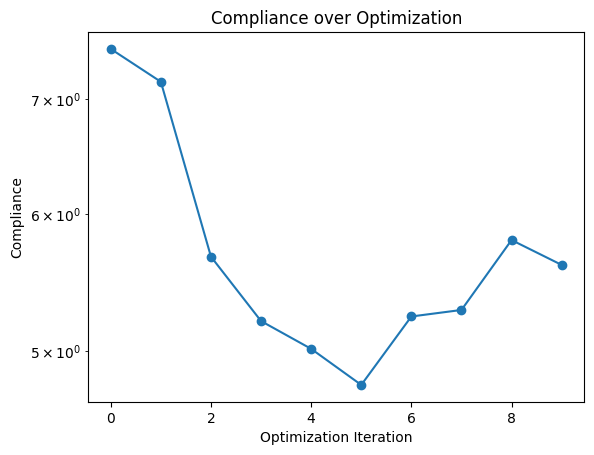

In [379]:
plt.plot(loss_hist, marker="o")
plt.yscale("log")
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization")

In [380]:
for i in range(n_steps):
    mesh = aux_hist[i]["hex_mesh"]
    rho_dot = grad_storage[i + 3000][1][: len(mesh["faces"])][:, 0]
    pv_mesh = hex_to_pyvista(
        mesh["points"], mesh["faces"], {"rho": mesh["rho"], "rho_dot": rho_dot}
    )
    pv_mesh.save(f"vtks/fem_shapeopt_mesh{i + 1}.vtk")

In [381]:
from matplotlib import animation

# repeat the last frame a few times to show the final result
params_hist = params_hist + [params] * 20

fig = plt.figure(figsize=(7, 4))

design_inputs["precompute_jacobian"] = False

ims = []
for aux in aux_hist:
    sdf = aux["sdf"]

    im = plt.imshow((sdf[:, :, :] > 0).sum(axis=1).T, origin="lower", cmap="viridis")
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=10, blit=False, repeat_delay=2)
plt.close(fig)

ani.save("rho_bars_optim.gif", writer="pillow", fps=10)

In [382]:
# lets visualize the 3d meshes over the optimization
for i, aux in enumerate(aux_hist):
    plot_mesh(aux["surface_mesh"], save_path=f"tmp_img/mesh_optim_{i:03d}.png")